In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from hough_circle_trafo import hough_circle
from utitlity_functions import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
from scipy import ndimage
import cv2 as cv
from matplotlib import cm
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from background_subtraction_gmm import Backsub as Backsub
np.random.seed(137)

# Example of plot

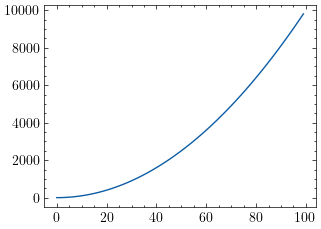

In [2]:
plt.style.use('science')
x=np.arange(100)
y=x**2
with plt.style.context('science'):
    plt.figure()
    plt.plot(x, y)
    plt.show()

# Hough Cirlce First

In [3]:
im=cv.imread("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t193.jpg", cv.IMREAD_GRAYSCALE)



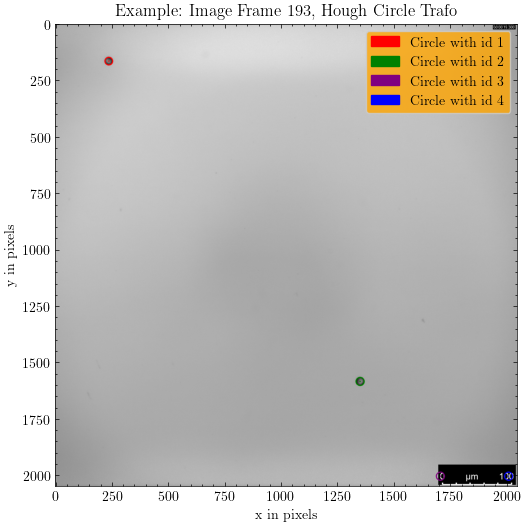

In [4]:
im_bgr=cv.cvtColor(im, cv.COLOR_GRAY2BGR)
circles=hough_circle(im_bgr)
# sort circles
circles=circles[circles[:, 0].argsort()]
colors=[(255, 0, 0), (0, 128, 0), (128, 0, 128), (0,0,255)]

for i,circle in enumerate(circles):
    center = (round(circle[0]), round(circle[1]))
    # circle outline
    radius = round(circle[2])
    # circle center
    cv.circle(im_bgr, center, 1, colors[i], 3)
    cv.circle(im_bgr, center, radius, colors[i], 3)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Hough Circle Trafo")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_bgr)
    red_patch = mpatches.Patch(color='red', label='Circle with id 1')
    green_patch = mpatches.Patch(color='green', label='Circle with id 2')
    purple_patch = mpatches.Patch(color='purple', label='Circle with id 3')
    blue_patch = mpatches.Patch(color='blue', label='Circle with id 4')
    plt.legend(handles=[red_patch, green_patch, purple_patch, blue_patch],frameon=True, facecolor="orange")
    plt.show()


# Background Segmentation

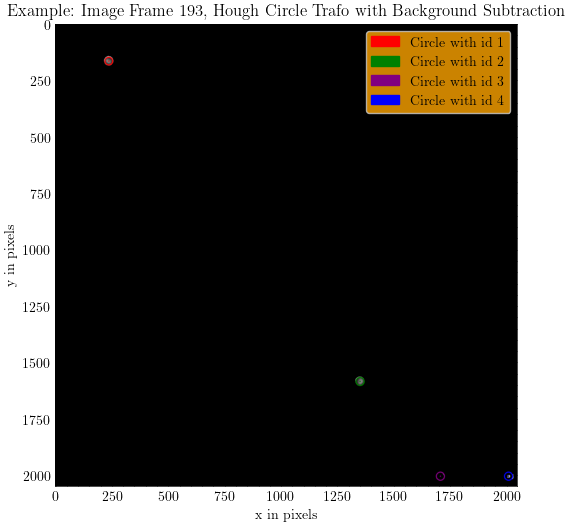

In [5]:
backsub=Backsub("../Video_Data/take_02.avi", history=100)
backsub.begin_train(max_frames=250)
mask=backsub.getMask(im_bgr)
foreground=np.copy(im_bgr)
foreground[mask==0]=0

colors=[(255, 0, 0), (0, 128, 0), (128, 0, 128), (0,0,255)]
for i,circle in enumerate(circles):
    center = (round(circle[0]), round(circle[1]))
    # circle outline
    radius = round(circle[2])
    # circle center
    cv.circle(foreground, center, 1, colors[i], 3)
    cv.circle(foreground, center, radius, colors[i], 3)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Hough Circle Trafo with Background Subtraction")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(foreground)
    red_patch = mpatches.Patch(color='red', label='Circle with id 1')
    green_patch = mpatches.Patch(color='green', label='Circle with id 2')
    purple_patch = mpatches.Patch(color='purple', label='Circle with id 3')
    blue_patch = mpatches.Patch(color='blue', label='Circle with id 4')
    plt.legend(handles=[red_patch, green_patch, purple_patch, blue_patch],frameon=True, facecolor="orange")
    plt.show()

# Getting ROI

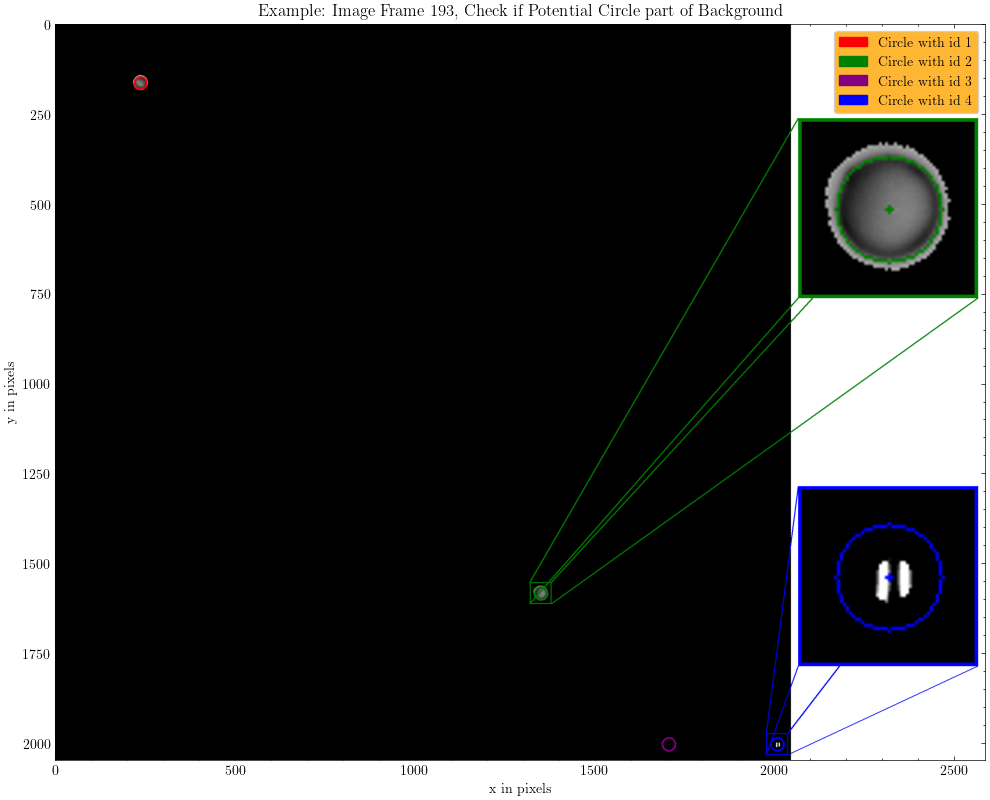

In [6]:
im_bgr=cv.cvtColor(im, cv.COLOR_GRAY2BGR)
mask=backsub.getMask(im_bgr)
foreground=np.copy(im_bgr)
foreground[mask==0]=0
foreground=cv.cvtColor(foreground,cv.COLOR_BGR2RGB)
for i,circle in enumerate(circles):
    center = (round(circle[0]), round(circle[1]))
    # circle outline
    radius = round(circle[2])
    # circle center
    cv.circle(foreground, center, 1, colors[i], -1)
    cv.circle(foreground, center, radius, colors[i], 3)
original_image_with_circles=Image.fromarray(foreground, mode='RGB')

im_bgr=cv.cvtColor(im, cv.COLOR_GRAY2BGR)
mask=backsub.getMask(im_bgr)
foreground=np.copy(im_bgr)
foreground[mask==0]=0
foreground=cv.cvtColor(foreground,cv.COLOR_BGR2RGB)
for i,circle in enumerate(circles):
    center = (round(circle[0]), round(circle[1]))
    # circle outline
    radius = round(circle[2])
    # circle center
    cv.circle(foreground, center, 1, colors[i], -1)
    cv.circle(foreground, center, radius, colors[i], 1)
original_image=Image.fromarray(foreground, mode='RGB')

resize_length=500
# Define the coordinates of the ROI rectangle (left, top, right, bottom)
a=30
x=circles[1,0]
y=circles[1,1]
x1_1=x-a
x2_1=x+a
y1_1=y-a
y2_1=y+a
roi_coordinates_1 = (x1_1, y1_1, x2_1, y2_1)  # Update these values

# Crop the ROI from the original image
roi_1 = original_image.crop(roi_coordinates_1)

# Enlarge the ROI
enlarged_roi_1 = roi_1.resize((resize_length, resize_length))  # Update new_width and new_height

x=circles[3,0]
y=circles[3,1]
x1_2=x-a
x2_2=x+a
y1_2=y-a
y2_2=y+a
roi_coordinates_2 = (x1_2, y1_2, x2_2, y2_2)  # Update these values

# Crop the ROI from the original image
roi_2 = original_image.crop(roi_coordinates_2)

# Enlarge the ROI
enlarged_roi_2 = roi_2.resize((resize_length, resize_length))  # Update new_width and new_height

# Create a blank canvas for the illustration
illustration_width = original_image.width+enlarged_roi_1.width + 40  # Adjust as needed
illustration_height = max(original_image.height, enlarged_roi_1.height)  # Adjust as needed
illustration = Image.new("RGB", (illustration_width, illustration_height), "white")

x1_1_new=original_image.width + 20
y1_1_new=((illustration_height//2)-resize_length)//2
x2_1_new=original_image.width + 20 + resize_length
y2_1_new=y1_1_new+resize_length

x1_2_new=original_image.width + 20
y1_2_new=(((illustration_height//2)-resize_length)//2)+(illustration_height//2)
x2_2_new=original_image.width + 20 + resize_length
y2_2_new=y1_2_new+resize_length

# Paste the original image on the canvas
illustration.paste(original_image_with_circles, (0, 0))  # Adjust the coordinates as needed
draw = ImageDraw.Draw(illustration)
draw.line(
    [(x2_1, y1_1), (x2_1_new, y1_1_new)],
    fill="green",
    width=3,
)
draw.line(
    [(x2_2, y1_2), (x2_2_new, y1_2_new)],
    fill="blue",
    width=3,
)

# Paste the enlarged ROI on the canvas
illustration.paste(enlarged_roi_1, (original_image.width + 20, y1_1_new))  # Adjust the coordinates as needed
illustration.paste(enlarged_roi_2, (original_image.width + 20, y1_2_new))  # Adjust the coordinates as needed


draw.rectangle(roi_coordinates_1, outline="green", width=3)
shape2=(x1_1_new, y1_1_new, x2_1_new, y2_1_new)
draw.rectangle(shape2, outline="green",width=10)
draw.line(
    [(x1_1, y1_1), (x1_1_new, y1_1_new)],
    fill="green",
    width=3,
)
draw.line(
    [(x1_1, y2_1), (x1_1_new, y2_1_new)],
    fill="green",
    width=3,
)
draw.line(
    [(x2_1, y2_1), (x2_1_new, y2_1_new)],
    fill="green",
    width=3,
)

draw.rectangle(roi_coordinates_2, outline="blue", width=3)
shape2=(x1_2_new, y1_2_new, x2_2_new, y2_2_new)
draw.rectangle(shape2, outline="blue",width=10)
draw.line(
    [(x1_2, y1_2), (x1_2_new, y1_2_new)],
    fill="blue",
    width=3,
)
draw.line(
    [(x1_2, y2_2), (x1_2_new, y2_2_new)],
    fill="blue",
    width=3,
)
draw.line(
    [(x2_2, y2_2), (x2_2_new, y2_2_new)],
    fill="blue",
    width=3,
)


with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Check if Potential Circle part of Background")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(illustration,cmap="gray")
    red_patch = mpatches.Patch(color='red', label='Circle with id 1')
    green_patch = mpatches.Patch(color='green', label='Circle with id 2')
    purple_patch = mpatches.Patch(color='purple', label='Circle with id 3')
    blue_patch = mpatches.Patch(color='blue', label='Circle with id 4')
    plt.legend(handles=[red_patch, green_patch, purple_patch, blue_patch],frameon=True, facecolor="orange")
    plt.show()